# Raster Grids

Climate data like temperatures, pollutant values are often represented as rasters. In this script, we will plot one such climate data variable over India at 0.1 degree gridsize resolution

In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
# Load India grids (0.1 degrees) shape file. 
# This is the canvas on which we are going to plot climate data
grids = gpd.read_file('assets/india_grid/grids-0.1x0.1deg/grids_india.shp')
grids = grids.set_crs('EPSG:4326')
grids.head()

,Maille,Maille_Y,Maille_X,X,Y,X1,Y1,X2,Y2,area_cell,geometry
0,1,1,1,67.05,7.05,67.0,7.0,67.1,7.1,129.551925,"POLYGON ((67.00000 7.10000, 67.10000 7.10000, ..."
1,2,1,2,67.15,7.05,67.1,7.0,67.2,7.1,129.441074,"POLYGON ((67.10000 7.10000, 67.20000 7.10000, ..."
2,3,1,3,67.25,7.05,67.2,7.0,67.3,7.1,129.331145,"POLYGON ((67.20000 7.10000, 67.30000 7.10000, ..."
3,4,1,4,67.35,7.05,67.3,7.0,67.4,7.1,129.222135,"POLYGON ((67.30000 7.10000, 67.40000 7.10000, ..."
4,5,1,5,67.45,7.05,67.4,7.0,67.5,7.1,129.114042,"POLYGON ((67.40000 7.10000, 67.50000 7.10000, ..."


1. `X` and `Y` are midpoints of each of the grids
2. `X1`, `Y1` is the lower left vertex of the grid
3. `X2`, `Y2` is the upper right vertex of the grid
4. `Maille_X` is the increasing index of latitudes.
5. `Maille_Y` is the increasing index of longitudes.

In [3]:
grids.shape

(102400, 11)

In [4]:
# Load the dataset which has climate data at 0.1 degree resolution for the same extent as the grids file.
df = pd.read_csv('data/indiasubcont_satpm_allyears.csv')[['ix', 'iy','Y1999']].reset_index()
df.head()

,level_0,level_1,ix,iy,Y1999
0,1,1,67.05,7.05,0.0
1,2,1,67.15,7.05,0.0
2,3,1,67.25,7.05,0.0
3,4,1,67.35,7.05,0.0
4,5,1,67.45,7.05,0.0


This is a PM2.5 Dataset.
1. `ix` and `iy` are the midpoints of each of the grids. 
2. `Y1998` is the value of `PM2.5` in that grid for the year 1998.
3. `level_0` is the increasing index of latitudes.
4. `level_1` is the increasing index of longitudes.

In [5]:
df.shape

(102400, 5)

In [6]:
# Add the climate data values to the grids shapefile.
# We can use the Maille variable
grids_df = pd.merge(grids, df, left_on=['Maille_X','Maille_Y'], right_on=['level_0','level_1'])
grids_df.tail()

,Maille,Maille_Y,Maille_X,X,Y,X1,Y1,X2,Y2,area_cell,geometry,level_0,level_1,ix,iy,Y1999
102395,102396,320,316,98.55,38.95,98.5,38.9,98.6,39.0,101.776537,"POLYGON ((98.50000 39.00000, 98.60000 39.00000...",316,320,98.55,38.95,24.9
102396,102397,320,317,98.65,38.95,98.6,38.9,98.7,39.0,101.842351,"POLYGON ((98.60000 39.00000, 98.70000 39.00000...",317,320,98.65,38.95,24.5
102397,102398,320,318,98.75,38.95,98.7,38.9,98.8,39.0,101.908576,"POLYGON ((98.70000 39.00000, 98.80000 39.00000...",318,320,98.75,38.95,25.2
102398,102399,320,319,98.85,38.95,98.8,38.9,98.9,39.0,101.975212,"POLYGON ((98.80000 39.00000, 98.90000 39.00000...",319,320,98.85,38.95,27.2
102399,102400,320,320,98.95,38.95,98.9,38.9,99.0,39.0,102.042259,"POLYGON ((98.90000 39.00000, 99.00000 39.00000...",320,320,98.95,38.95,28.9


**Data check:** 
1. If the dataset and grids are of same extent, the number of grids will be the same after merging both
2. Ensure that you are merging latitude indices and longitude indices correctly. Otherwise, the final raster could be flipped.

## 1. Basic Raster Plot

In [7]:
import matplotlib.pyplot as plt

In [8]:
# Load base map shapefile
base_map = gpd.read_file("assets/INDIA_STATES.geojson")
base_map['common'] = 'c'
india = base_map.dissolve('common')

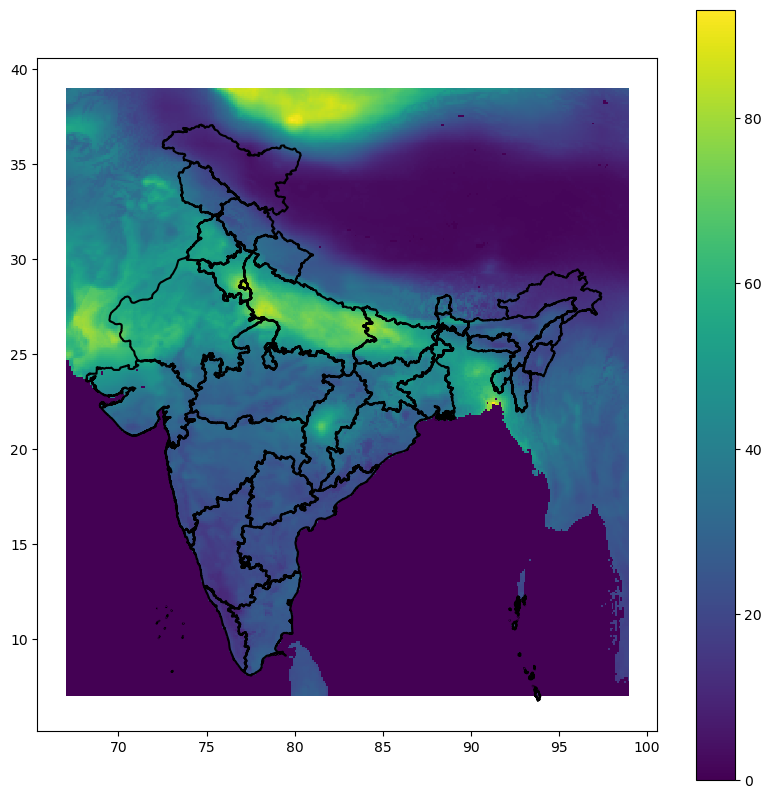

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

## Plot grids_masked for the masked map
grids_df.plot(column='Y1999',
                  alpha=1, #Transparency
                  legend=True,
                  ax=ax)
# Plot base map
base_map.boundary.plot(ax=ax, color="black")

plt.show()

## 2. Basic Raster Plot with color bins

Instead of plotting the climate data as it is, we can bin them based on scientific standards (Eg: AQI categories) and plot associated colors.

In [11]:
# Function to bin PM2.5 values 
def bin(x):
    if x< 5:
        return 0 #Dark Green
    elif x < 20:
        return 1 #Light Green
    elif x < 40:
        return 2 #Light brown
    elif x < 50:
        return 3 #Medium Brown
    elif x < 60:
        return 4 #Light orange
    elif x < 80:
        return 5 #Orange
    elif x < 100:
        return 6 #Red
    else:
        return 7 #Dark brown

In [12]:
grids_df['bin'] = grids_df["Y1999"].apply(bin)

In [14]:
sorted(grids_df['bin'].unique())

[0, 1, 2, 3, 4, 5, 6]

In [18]:
# Optionally, you can create a custom color map for each of the categories created above
from matplotlib.colors import LinearSegmentedColormap
colors = ['#006634', #Dark Green
          '#33cc33', #Light green
          '#cccd33', #Light brown
          '#c09d01', #Medium brown
          '#ffcc00', #Light orange
          '#fe6635', #Orange
          '#fe0000', #Red
          '#653331' #Dark Brown
          ]  # Define your colors
cmap_name = 'custom_cmap'

colors = [colors[i] for i in sorted(grids_df['bin'].unique())]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(colors))

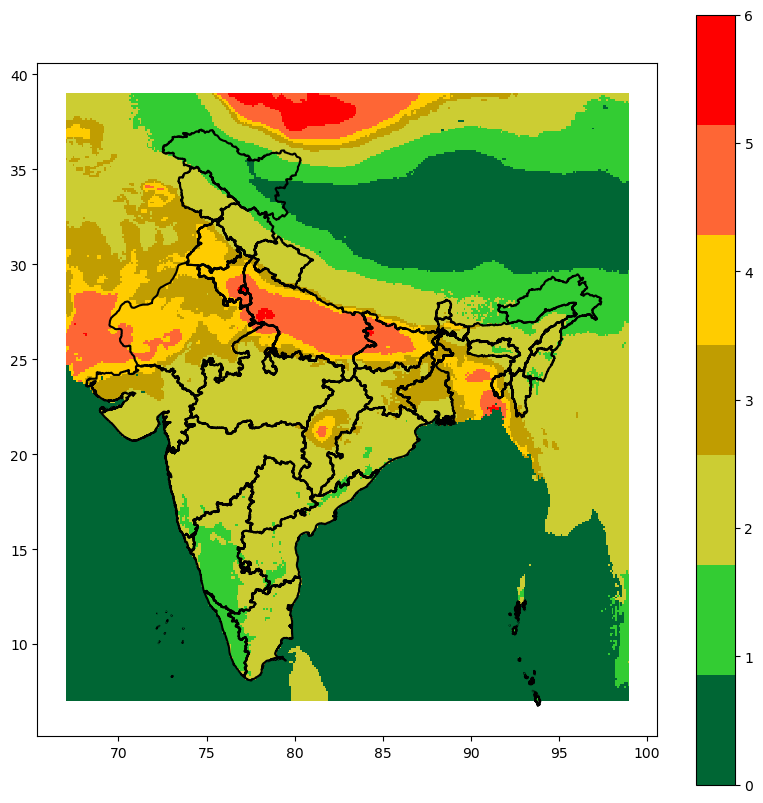

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

## Plot grids_masked for the masked map
grids_df.plot(column='bin',
              cmap=custom_cmap,
              alpha=1, #Transparency
              legend=True,
              ax=ax)

# Plot base map
base_map.boundary.plot(ax=ax, color="black")

plt.show()

## 3. Masked Rasters 

If you don't want to plot the grids that are outside Indian boundary, we can mask them.<br>
We will select only those grids that fall within or intersect with India's national boundaries

In [21]:
#Masking
grids_df_masked = gpd.sjoin(grids_df, india, predicate='intersects') 
#predicate='within' is computationally faster - but it will miss grids that intersect with boundaries.

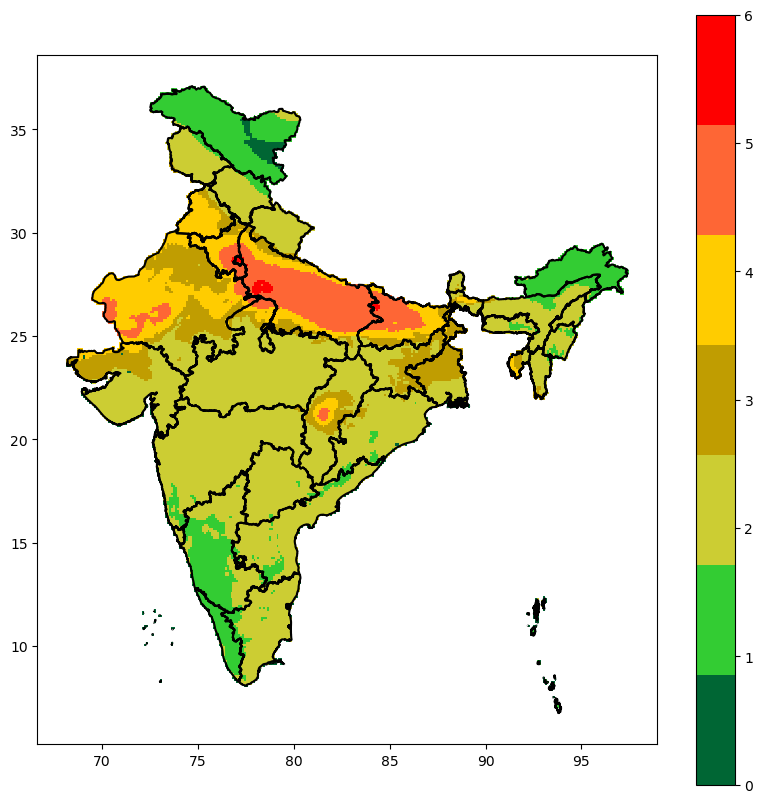

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

## Plot grids_masked for the masked map
grids_df_masked.plot(column='bin',
                cmap=custom_cmap,
                alpha=1,
                legend=True,
                ax=ax)

# Plot base map
base_map.boundary.plot(ax=ax, color="black")

plt.show()

## Additional Formatting

1. Adding text annotations
2. Adding Logos
3. Adding custom legend

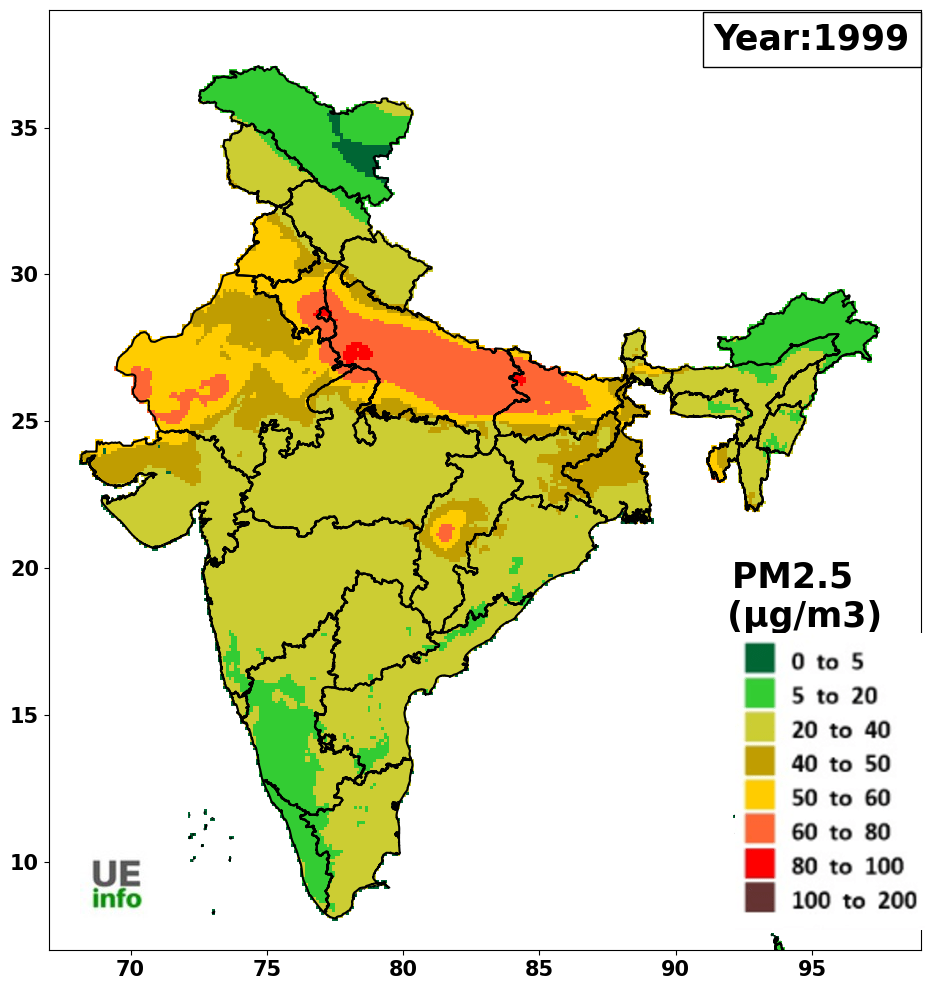

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

## Plot grids_masked for the masked map
grids_df_masked.plot(column='bin',
                cmap=custom_cmap,
                alpha=1,
                #legend=True,
                ax=ax)
# Plot base map
base_map.boundary.plot(ax=ax, color="black")

# Set limits to tightly fit the data
ax.set_xlim(grids.X1.min(), grids.X2.max())
ax.set_ylim(grids.Y1.min(), grids.Y2.max())

plt.xticks(weight = 'bold', fontsize=15)
plt.yticks(weight = 'bold', fontsize=15)

#Add year - month annotation
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=1)
plt.text(95, 38,
         'Year:1999',
         fontsize=25, fontweight='bold', color='black',
         ha='center', va='center',
             bbox=bbox_props)
    
# Add legend - custom image
legend_img = plt.imread('assets/legend_mask_resized.png')  # Provide the path to your image file
plt.figimage(legend_img, xo=735, yo=60)

# Annotate Legend title
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="white", lw=1)
plt.text(94.5, 19,
         'PM2.5 \n (μg/m3)',
         fontsize=25, fontweight='bold', color='black',
         ha='center', va='center',
             bbox=bbox_props)
    
# Add logo
logo = plt.imread('assets/UEinfo_logo3_resized_70.jpg')  # Provide the path to your image file
plt.figimage(logo, xo=80, yo=70)

plt.tight_layout()

plt.savefig("visuals/RasterGrids_masked.png")